In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [448]:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx', index_col='date')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2011-11-30 to 2024-10-31
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fob_urea_kg                       150 non-null    float64
 1   crude_oil_brent_usd_per_bbl       154 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu  154 non-null    float64
 3   inflación_mensual                 154 non-null    float64
 4   ipc_diesel                        140 non-null    float64
 5   precipitación_media_mm            146 non-null    float64
 6   temp_media_Celsius                146 non-null    float64
 7   baltic_dry_idx_last               154 non-null    float64
 8   pct_pobreza_rural                 145 non-null    float64
 9   fosfato diamónico 18-46-0         140 non-null    float64
 10  muriato de potasio 0-0-60         140 non-null    float64
 11  urea 46-0-0                       140 non-null    fl

In [449]:
df = df.rename(
    columns={
        "fosfato diamónico 18-46-0":"pvp_dap",
        "muriato de potasio 0-0-60":"pvp_mop",
        "urea 46-0-0":"pvp_urea"
        }
    )

### Ingeniería de variables

In [450]:
# Transformar la precipitación en milímetros a metros:
df['precipitación_media_m'] = df['precipitación_media_mm'] / 1000
df = df.drop(columns=['precipitación_media_mm'])

# Variable de precipitación cuadrada:
df['precipitación_media_m2'] = df['precipitación_media_m'] ** 2

# Calcular coeficiente de variación de precipitación y temperatura:
vars_climáticas = {'precipitación':'precipitación_media_m', 'temperatura':'temp_media_Celsius'}

for name, var in vars_climáticas.items():
    df['coef_var_' + name] = df[var].rolling(window=12).std() / df[var].rolling(window=12).mean()

# # Variable de interacción climática:
# df['interacción_climática'] = df['precipitación_media_m'] * df['temp_media_Celsius']

In [451]:
# Eliminar NaN:
df_sin_na = df.dropna()

# Crear DataFrame para variables logarítmicas:
ln_data = pd.DataFrame(index=df_sin_na.index)

# Variables porcentuales:
variables_no_log_transformables = ['inflación_mensual', 'pct_pobreza_rural', 'precipitación_media_m', 'precipitación_media_m2', 'coef_var_precipitación', 'coef_var_temperatura']

# Transformación logarítmica de las variables:
for col in df_sin_na.columns:
    
    # Transformación logarítmica de las variables no transformables:
    if col not in variables_no_log_transformables:
        ln_data['ln_' + col] = df_sin_na[col].apply(np.log)
    else:
        ln_data[col] = df_sin_na[col]

ln_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ln_fob_urea_kg                       132 non-null    float64
 1   ln_crude_oil_brent_usd_per_bbl       132 non-null    float64
 2   ln_natural_gas_europe_usd_per_mmbtu  132 non-null    float64
 3   inflación_mensual                    132 non-null    float64
 4   ln_ipc_diesel                        132 non-null    float64
 5   ln_temp_media_Celsius                132 non-null    float64
 6   ln_baltic_dry_idx_last               132 non-null    float64
 7   pct_pobreza_rural                    132 non-null    float64
 8   ln_pvp_dap                           132 non-null    float64
 9   ln_pvp_mop                           132 non-null    float64
 10  ln_pvp_urea                          132 non-null    float64
 11  precipitación

In [452]:
# Lista de variables fertilizantes:
lista_fertilizantes = ['ln_pvp_dap', 'ln_pvp_mop', 'ln_pvp_urea']

# Variables excluidas:
variables_excluidas = [] # 'precipitación_media_m2'] #, 'inflación_mensual', 'ln_natural_gas_europe_usd_per_mmbtu', 'ln_temp_media_Celsius', 'pct_pobreza_rural'] #, 'ln_natural_gas_europe_usd_per_mmbtu']

# Extraer variables predictoras:
X = ln_data.drop(columns=lista_fertilizantes + variables_excluidas)

# Extraer variable objetivo:
target_var = 'ln_pvp_urea'
y = ln_data[target_var]

In [453]:
# Calcular el factor de inflación de varianza (VIF) de las variables explicativas originales:
calcular_vif(X)

,Variable,VIF
0,precipitación_media_m,46.247827
1,precipitación_media_m2,43.261685
2,ln_natural_gas_europe_usd_per_mmbtu,11.918606
3,ln_fob_urea_kg,7.860458
4,ln_ipc_diesel,5.423092
5,ln_crude_oil_brent_usd_per_bbl,4.593934
6,ln_temp_media_Celsius,2.882527
7,ln_baltic_dry_idx_last,2.528477
8,pct_pobreza_rural,2.335188
9,coef_var_precipitación,1.803006


In [454]:
modelo_rls_significativo, variables_significativas = ols_backward_elimination(X, y, significance_level=0.05)

print(modelo_rls_significativo.summary())

variable eliminada: precipitación_media_m; p-valor: 0.9686
variable eliminada: inflación_mensual; p-valor: 0.8513
variable eliminada: ln_natural_gas_europe_usd_per_mmbtu; p-valor: 0.7208
variable eliminada: ln_temp_media_Celsius; p-valor: 0.6988
variable eliminada: coef_var_temperatura; p-valor: 0.6155
variable eliminada: pct_pobreza_rural; p-valor: 0.1528
variable eliminada: precipitación_media_m2; p-valor: 0.1037
                            OLS Regression Results                            
Dep. Variable:            ln_pvp_urea   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     213.7
Date:               ju., 05 dic. 2024   Prob (F-statistic):           9.40e-60
Time:                        08:03:09   Log-Likelihood:                 120.30
No. Observations:                 132   AIC:                            -228.6
Df Residuals:               

In [455]:
calcular_vif(X[variables_significativas])

,Variable,VIF
0,ln_fob_urea_kg,3.899122
1,ln_ipc_diesel,3.276671
2,ln_crude_oil_brent_usd_per_bbl,1.885509
3,ln_baltic_dry_idx_last,1.504493
4,coef_var_precipitación,1.341023


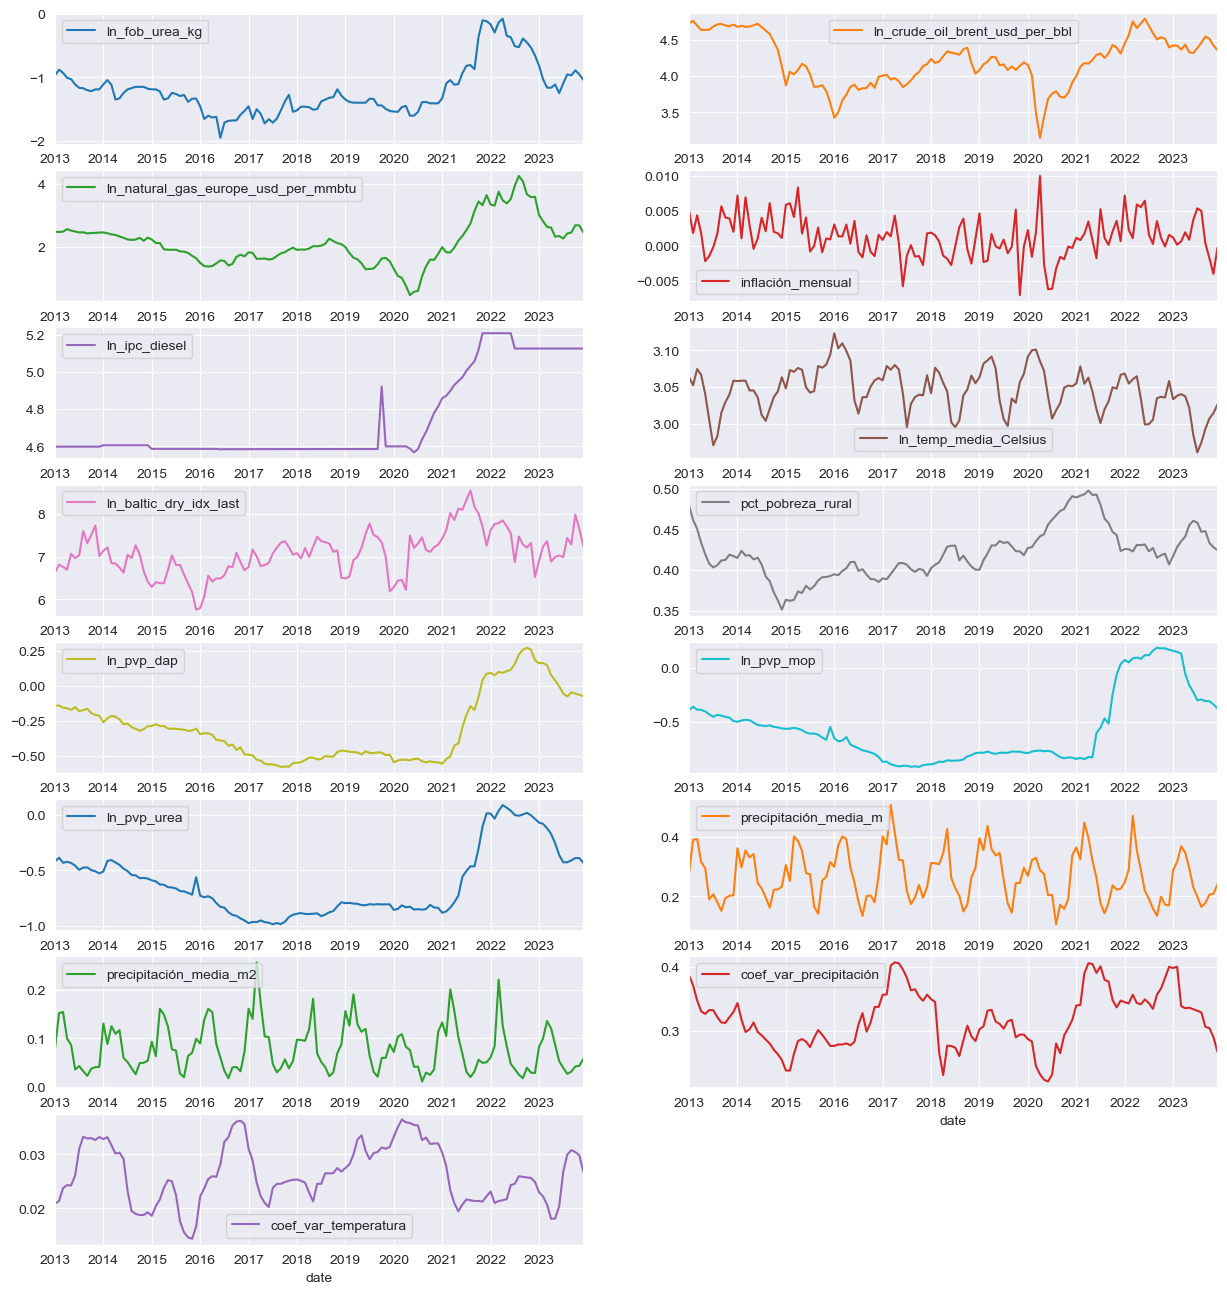

In [456]:
num_de_filas = ((ln_data.shape[1] + 1) // 2)

ln_data.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

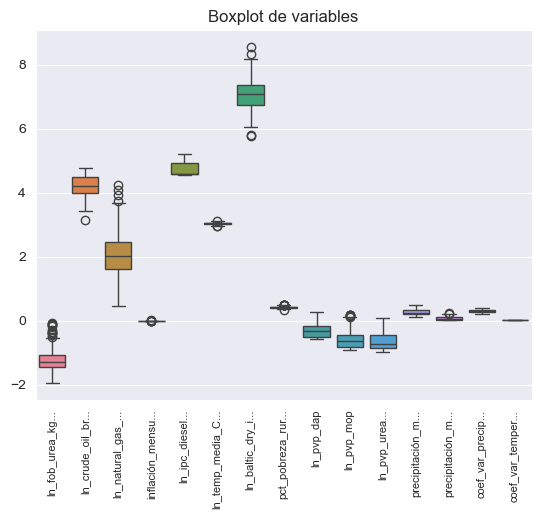

In [457]:
truncated_labels = [col[:15] + "..." if len(col) > 10 else col for col in ln_data.columns]
posición_ticks = np.arange(len(ln_data.columns))

sns.boxplot(ln_data)
plt.xticks(ticks=posición_ticks, labels=truncated_labels, rotation=90, size=8)
plt.title("Boxplot de variables")
plt.show()

### Correlaciones y colinealidad

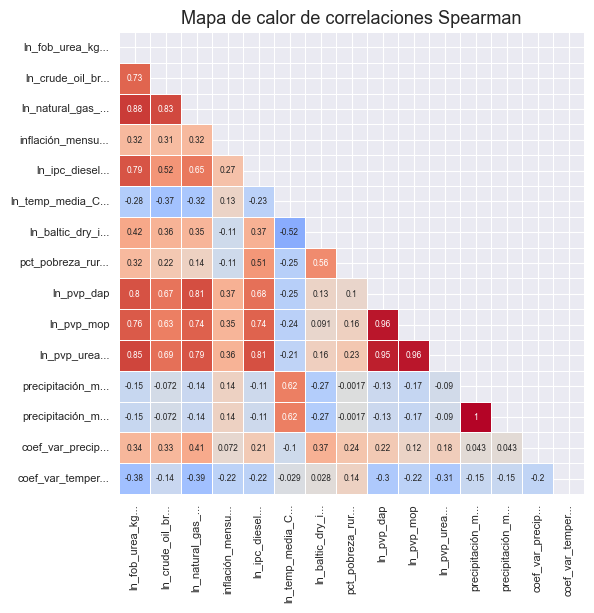

In [458]:
# Método de cálculo de correlaciones:
method = 'spearman'

posición_ticks = np.arange(len(ln_data.columns)) + 0.5

# Graficar mapa de calor de correlaciones no lineales:
corr = ln_data.corr(method=method) # 'pearson', 'spearman', 'kendall'
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(6, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 6}, cbar=False)
plt.title(f'Mapa de calor de correlaciones {method.capitalize()}', size=13)
plt.xticks(ticks=posición_ticks, labels=truncated_labels, fontsize=8)
plt.yticks(ticks=posición_ticks, labels=truncated_labels, fontsize=8)
plt.show()

## VECM

### Revisar VIF de variables para VECM

In [459]:
# Eliminar variables independientes no necesarias del modelo VECM:
X_vecm = X.drop(columns=['precipitación_media_m', 'pct_pobreza_rural', 'precipitación_media_m2', 'ln_natural_gas_europe_usd_per_mmbtu', 'ln_temp_media_Celsius', 'coef_var_temperatura'])

# Revisar VIF de variables para VECM:
print(calcular_vif(X_vecm))

# Adjuntar variable objetivo a variables del modelo VECM:
vars_modelo_vecm = X_vecm.columns.tolist()
vars_modelo_vecm.append(target_var)

# Crear DataFrame:
df_vars_vecm = ln_data[vars_modelo_vecm]

                         Variable       VIF
0                  ln_fob_urea_kg  4.090878
1                   ln_ipc_diesel  3.279494
2  ln_crude_oil_brent_usd_per_bbl  1.906729
3          ln_baltic_dry_idx_last  1.619045
4          coef_var_precipitación  1.341492
5               inflación_mensual  1.213575


In [460]:
# plot_scatter_matrix(df_vars_vecm) #, trendline=True)

### Primer supuesto VECM: variables son no estacionarias en niveles (forma original)

In [461]:
# Revisar si las variables son no estacionarias bajo supuesto del modelo VECM:
evaluar_estacionareidad_vars = evaluar_estacionareidad(df_vars_vecm)

evaluar_estacionareidad_vars

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,ln_fob_urea_kg,2.167094e-01,0.020516,False,True,No estacionario
1,ln_crude_oil_brent_usd_per_bbl,2.125865e-01,0.100000,False,False,No claro
2,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
3,ln_ipc_diesel,9.634624e-01,0.010000,False,True,No estacionario
4,ln_baltic_dry_idx_last,8.641307e-03,0.010000,True,True,No claro
5,coef_var_precipitación,1.305295e-01,0.100000,False,False,No claro
6,ln_pvp_urea,2.561894e-01,0.029500,False,True,No estacionario


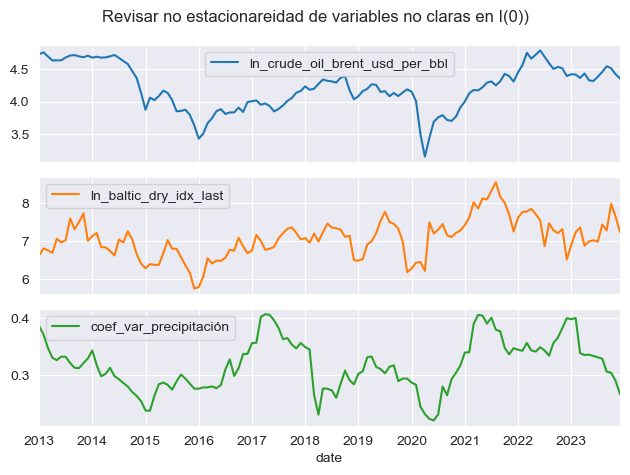

In [462]:
# Filtrar variables con estacionareidad no clara:
estacionareidad_no_clara = df_vars_vecm[evaluar_estacionareidad_vars.query("estado_estacionario == 'No claro'")['variable']]

# Revisar estacionareidad visualmente:
estacionareidad_no_clara.plot(subplots=True)
plt.suptitle("Revisar no estacionareidad de variables no claras en I(0))")
plt.tight_layout()
plt.show()

**Conclusión 1:** A pesar de que en niveles existen variables con resultado de estacionareidad "no claro", visualmente existe un grado alto de plausibilidad de que estas variables son no estacionarias.

### Segundo supuesto VECM: las variables son estacionarias tras I(1)

In [463]:
# Evaluar estacionareidad de cada variable por ADF y KPSS:
evaluar_estacionareidad_vars = evaluar_estacionareidad(df_vars_vecm)

# Obtener lista de variables no estacionarias:
variables_no_estacionarias = evaluar_estacionareidad_vars.query("estado_estacionario != 'Estacionario'")['variable'].tolist()

df_no_estacionarias_I1 = df_vars_vecm[variables_no_estacionarias]\
    .diff()\
    .dropna()\
    .add_suffix("_d1")

# Evaluar si las variables no estacionarias se convierten tras primera diferenciación:
evaluar_estacionareidad_vars_I1 = evaluar_estacionareidad(df_no_estacionarias_I1)

evaluar_estacionareidad_vars_I1


,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,ln_fob_urea_kg_d1,6.782078e-02,0.1,False,False,No claro
1,ln_crude_oil_brent_usd_per_bbl_d1,3.572860e-13,0.1,True,False,Estacionario
2,ln_ipc_diesel_d1,3.881646e-29,0.1,True,False,Estacionario
3,ln_baltic_dry_idx_last_d1,6.231103e-24,0.1,True,False,Estacionario
4,coef_var_precipitación_d1,6.099490e-05,0.1,True,False,Estacionario
5,ln_pvp_urea_d1,4.619871e-02,0.1,True,False,Estacionario


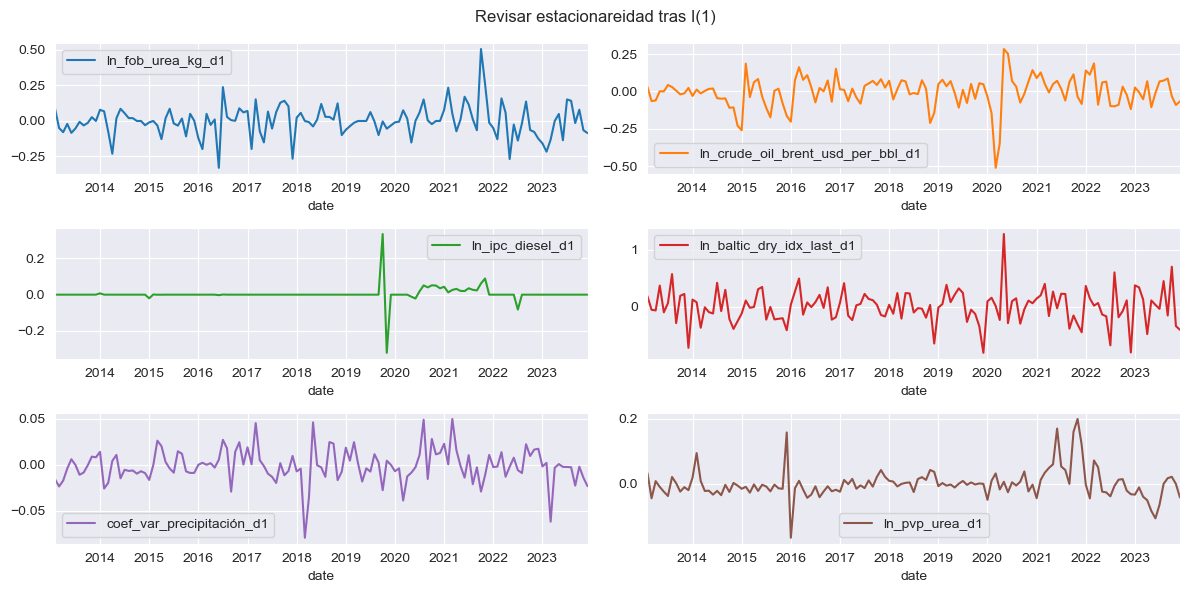

In [464]:
num_de_filas = ((df_no_estacionarias_I1.shape[1] + 1) // 2)

df_no_estacionarias_I1.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(12, 2 * num_de_filas),
    sharex=False
    )
plt.suptitle("Revisar estacionareidad tras I(1)")
plt.tight_layout()
plt.show()

**Conclusión:** Aunque algunos resultados de estacionareidad tras I(1) por KPSS y ADF aparecen como "no claros", las gráficas sugieren con alto grado de plausibilidad que todas las variables son estacionarias. Por tanto, se cumple el segundo supuesto del modelo VECM.

### Ruptura estructural

In [465]:
# Crear dataframe solamente con variables no estacionarias:
df_test_cointegración = df_vars_vecm[variables_no_estacionarias]

# Crear dataframe de variables exógenas al modelo de cointegración (en este caso, las variables estacionarias):
set_vars_exógenas = set(df_vars_vecm.columns) - set(variables_no_estacionarias)
df_exógenas_vecm = df_vars_vecm[list(set_vars_exógenas)]

# # Eliminar las variables fertilizantes que no son de interés: 
# columns_to_drop = [col for col in lista_fertilizantes if col != target_var]

# df_test_cointegración = df_no_estacionarias.drop(columns=columns_to_drop)

print("Variables seleccionadas como exógenas al ser estacionarias: ", set_vars_exógenas)

Variables seleccionadas como exógenas al ser estacionarias:  {'inflación_mensual'}


In [466]:
# Dividir en variable dependiente e independientes
y = df_test_cointegración['ln_pvp_urea']
X = df_test_cointegración.drop(columns=['ln_pvp_urea'])

# Detectar rupturas estructurales
ruptura_estructural = detect_structural_breaks(y, X, model_type="l2", n_bkps=2)

# Mostrar resultados
print(ruptura_estructural)

  break_date  F-Statistic   p-value
0 2015-02-28    24.248840  0.000003
1 2021-05-31    12.545795  0.000559


In [467]:
# Crear DataFrame vacío con el mismo índice que df_test_cointegración:
dummies_ruptura = pd.DataFrame(index=df_test_cointegración.index)

# Ordenar las fechas de ruptura
fechas_ruptura = sorted(pd.to_datetime(ruptura_estructural['break_date'].values))

# Iterar sobre las fechas de ruptura, manejando intervalos entre rupturas
for i, fecha in enumerate(fechas_ruptura):
    # Formatear la fecha para el nombre de la columna
    str_fecha = fecha.strftime('%b%Y').replace(".", "_")
    
    # Definir el fin del intervalo como la siguiente fecha de ruptura o el final del índice
    if i < len(fechas_ruptura) - 1:
        fin_intervalo = fechas_ruptura[i + 1]
    else:
        fin_intervalo = dummies_ruptura.index.max() + pd.Timedelta(days=1)  # Asegura incluir el último día
    
    # Crear la dummy para el intervalo actual
    dummies_ruptura['ruptura_' + str_fecha] = (
        (dummies_ruptura.index >= fecha) & (dummies_ruptura.index < fin_intervalo)
    ).astype(int)

# with pd.option_context('display.max_rows', None):
#     print(dummies_ruptura)

# Unir variables dummy al DataFrame de variables exógenas:
df_exógenas_vecm = df_exógenas_vecm.join(dummies_ruptura, how="inner") 

dummies_ruptura.sum()

ruptura_feb_2015    75
ruptura_may_2021    32
dtype: int64

In [468]:
df_exógenas_vecm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inflación_mensual  132 non-null    float64
 1   ruptura_feb_2015   132 non-null    int32  
 2   ruptura_may_2021   132 non-null    int32  
dtypes: float64(1), int32(2)
memory usage: 3.1 KB


### Cointegración

El **Vector AutoRegresivo** (VAR) es un modelo econométrico que captura las relaciones dinámicas entre varias series temporales tratándolas como variables endógenas. A diferencia de modelos univariados, el VAR permite que cada variable dependa de sus propios rezagos y de los rezagos de las demás, sin suponer relaciones causales específicas. Esto lo hace útil para analizar cómo los cambios en una variable afectan a las demás a lo largo del tiempo. Es ideal para identificar patrones de interdependencia y realizar análisis de impacto como impulso-respuesta o descomposición de varianza.

In [469]:
from statsmodels.tsa.api import VAR

# Ajusta un modelo VAR preliminar
modelo_var = VAR(df_test_cointegración, freq='ME')
orden_rezagos = modelo_var.select_order(maxlags=12)
print(orden_rezagos.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -21.43      -21.29   4.938e-10      -21.37
1      -32.48*     -31.50*  7.853e-15*     -32.08*
2       -32.45      -30.64   8.089e-15      -31.72
3       -32.25      -29.61   9.980e-15      -31.18
4       -32.02      -28.53   1.292e-14      -30.60
5       -31.89      -27.56   1.526e-14      -30.13
6       -31.84      -26.69   1.677e-14      -29.75
7       -31.74      -25.75   1.998e-14      -29.31
8       -31.55      -24.72   2.681e-14      -28.78
9       -31.56      -23.89   3.073e-14      -28.44
10      -31.60      -23.10   3.539e-14      -28.15
11      -31.79      -22.45   3.708e-14      -28.00
12      -32.05      -21.88   3.894e-14      -27.92
--------------------------------------------------


In [470]:
# Obtener el valor de lags óptimo según HQIC:
criterio = 'aic'
maxlags_óptimo = orden_rezagos.selected_orders[criterio]

print(f"Número de lags óptimo según criterio {criterio.upper()}: ", maxlags_óptimo)

Número de lags óptimo según criterio AIC:  1


La **prueba de Johansen** es un método econométrico utilizado para identificar relaciones de equilibrio a largo plazo (cointegración) entre múltiples series temporales no estacionarias. A diferencia de otros enfoques, como *Engle-Granger*, permite analizar más de dos variables simultáneamente. La prueba utiliza un modelo VAR para evaluar si existe una combinación lineal estacionaria entre las series. Sus resultados indican cuántos vectores de cointegración existen, lo que ayuda a decidir si las variables tienen una relación estable a largo plazo y si se debe utilizar un modelo como el VECM para capturar dichas dinámicas.

In [471]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

cointegración_johansen = coint_johansen(df_test_cointegración, det_order=0, k_ar_diff=maxlags_óptimo)

estadísticos_de_traza = cointegración_johansen.lr1
valores_críticos = cointegración_johansen.cvt

print("Estadísticos de traza:\n", estadísticos_de_traza)
print("Valores críticos:\n[1% | 5% | 10%]\n", valores_críticos)

Estadísticos de traza:
 [133.22889373  75.17081712  37.74599918  21.74898395   9.08364583
   0.75033999]
Valores críticos:
[1% | 5% | 10%]
 [[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [472]:
# Extraer columna del 5% de nivel de confianza:
valores_críticos_5_pct = valores_críticos[:, 1]  

# Establecer vectores de cointegración base r=0:
r = 0

# Determinar r automáticamente:
for i, (trace, critical) in enumerate(zip(estadísticos_de_traza, valores_críticos_5_pct)):
    if trace > critical:
        # Incrementar r si se rechaza la hipótesis nula:
        r = i + 1

print(f"Número de vectores de cointegración (r): {r}")

Número de vectores de cointegración (r): 2


In [473]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Ajustar el modelo VECM
modelo_vecm = VECM(
    df_test_cointegración,
    exog=df_exógenas_vecm, # Variables estacionarias
    k_ar_diff=maxlags_óptimo,  # Número de rezagos diferenciales basado en el VAR
    coint_rank=r,  # Número de vectores de cointegración, según Johansen
    deterministic='cili',
    freq='ME'
    ).fit()

# Resumen del modelo
print(modelo_vecm.summary())

    Det. terms outside the coint. relation & lagged endog. parameters for equation ln_fob_urea_kg    
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
exog1                                 0.1757      3.195      0.055      0.956      -6.086       6.438
exog2                                 0.0248      0.020      1.215      0.224      -0.015       0.065
exog3                                -0.0235      0.026     -0.921      0.357      -0.073       0.026
L1.ln_fob_urea_kg                     0.0941      0.097      0.970      0.332      -0.096       0.284
L1.ln_crude_oil_brent_usd_per_bbl     0.2123      0.096      2.213      0.027       0.024       0.400
L1.ln_ipc_diesel                     -0.0045      0.215     -0.021      0.983      -0.426       0.417
L1.ln_baltic_dry_idx_last            -0.0441      0.035     -1.250      0.211     

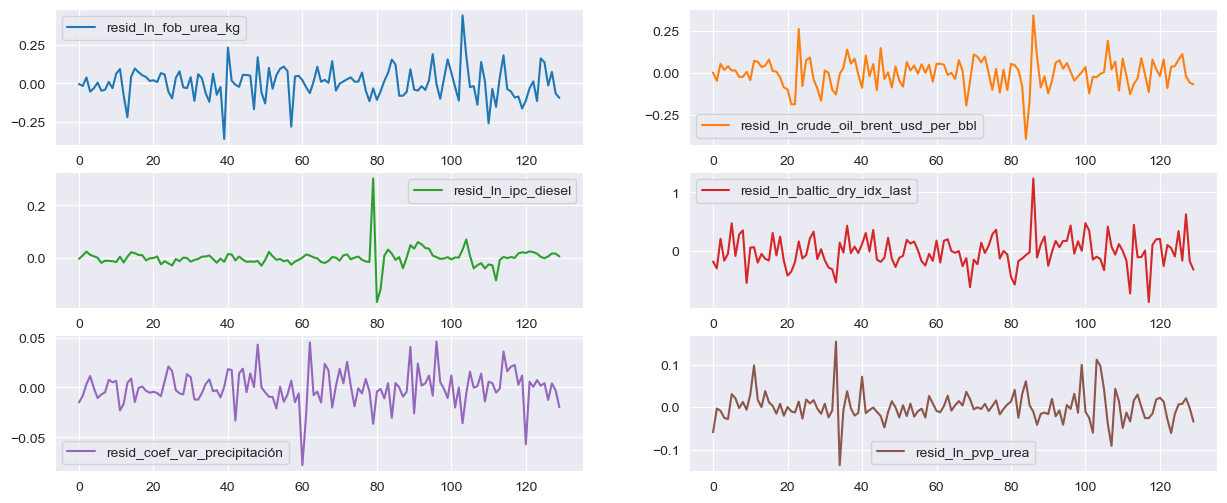

In [474]:
residuos_vecm = pd.DataFrame()

for var_name, resid in zip(df_test_cointegración.columns, modelo_vecm.resid.T):
    residuos_vecm["resid_" + var_name] = resid

num_de_filas = ((residuos_vecm.shape[1] + 1) // 2)

residuos_vecm.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

En un modelo VECM, la estacionariedad de los residuos es esencial para garantizar que las relaciones entre las variables estén correctamente especificadas y que el modelo no omita dinámicas importantes. Si los residuos no son estacionarios, esto podría indicar la presencia de patrones no capturados, como tendencias o ciclos, lo que comprometería la validez de las inferencias realizadas. Además, la estacionariedad previene problemas como las relaciones espurias, asegurando que las estimaciones reflejen vínculos económicos reales y no coincidencias estadísticas.

La evaluación conjunta de estacionariedad mediante las pruebas **Augmented Dickey-Fuller** (ADF) y **Kwiatkowski-Phillips-Schmidt-Shin** (KPSS) permite obtener una perspectiva más completa sobre la naturaleza de las series temporales. Estas pruebas abordan la estacionariedad desde enfoques opuestos: ADF detecta la presencia de raíces unitarias (es decir, no estacionariedad) asumiendo como hipótesis nula que la serie no es estacionaria, mientras que KPSS evalúa si existe tendencia o estructura no estacionaria, partiendo de la hipótesis nula de que la serie es estacionaria.

La combinación de ambos resultados facilita una evaluación robusta de la estacionareidad de los residuos. Una serie se considera estacionaria si ADF rechaza su hipótesis nula (p-valor bajo) y KPSS no la rechaza (p-valor alto). Por el contrario, se considera no estacionaria si ADF no rechaza su hipótesis nula (p-valor alto) o KPSS sí la rechaza (p-valor bajo). Este enfoque evita depender únicamente de un test, aumentando la precisión y confiabilidad del análisis.

In [475]:
# Evaluar estacionareidad de residuos del modelo VECM utilizando ADF y KPSS:
evaluar_estacionareidad_residuos_vecm = evaluar_estacionareidad(residuos_vecm)

evaluar_estacionareidad_residuos_vecm

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,resid_ln_fob_urea_kg,1.419113e-02,0.1,True,False,Estacionario
1,resid_ln_crude_oil_brent_usd_per_bbl,3.280571e-12,0.1,True,False,Estacionario
2,resid_ln_ipc_diesel,6.964517e-16,0.1,True,False,Estacionario
3,resid_ln_baltic_dry_idx_last,6.032472e-20,0.1,True,False,Estacionario
4,resid_coef_var_precipitación,4.101202e-06,0.1,True,False,Estacionario
5,resid_ln_pvp_urea,2.136580e-12,0.1,True,False,Estacionario


La **prueba de Ljung-Box** evalúa si los residuos de un modelo de series temporales son independientes, es decir, si no presentan autocorrelación. La independencia de los residuos garantiza que el modelo haya capturado adecuadamente las dinámicas de las variables y no existan patrones no modelados.

La hipótesis nula de la prueba plantea que no hay autocorrelación en los residuos, mientras que la hipótesis alternativa sugiere lo contrario. Un p-valor alto indica que los residuos son independientes, mientras que un p-valor bajo señala la presencia de autocorrelación y la posible necesidad de ajustar el modelo.

En modelos como el VECM, la prueba de Ljung-Box es clave para confirmar que las relaciones temporales han sido correctamente especificadas y que las inferencias basadas en el modelo son confiables.

In [476]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Crear un diccionario para almacenar los resultados
resultados_ljung_box = {}

# Iterar sobre cada columna (variable) del DataFrame de residuos
for column in residuos_vecm.columns:
    ljung_box = acorr_ljungbox(residuos_vecm[column], lags=10, return_df=True)  # Ajustar número de lags según sea necesario
    resultados_ljung_box[column] = ljung_box

# Convertir los resultados en un DataFrame para mejor visualización
df_ljung_box = pd.concat(resultados_ljung_box, axis=1)

# Mostrar los resultados
df_ljung_box


resid_ln_fob_urea_kg           resid_ln_crude_oil_brent_usd_per_bbl  \
                lb_stat lb_pvalue                              lb_stat   
1              0.000164  0.989768                             0.953296   
2              3.235521  0.198342                             3.620991   
3              3.571438  0.311614                             7.579987   
4              3.652138  0.455125                             8.738046   
5              4.928513  0.424667                             8.928173   
6              6.419179  0.377906                             8.952587   
7             12.607532  0.082268                             8.971098   
8             16.000209  0.042377                             8.972885   
9             17.402991  0.042767                             9.178676   
10            22.154475  0.014337                             9.227210   

             resid_ln_ipc_diesel           resid_ln_baltic_dry_idx_last  \
   lb_pvalue             lb_stat lb_pvalue                      lb_stat   
1   0.328882            0.209087  0.647484                     0.046919   
2   0.163573            3.184527  0.203465                     0.630504   
3   0.055538            3.427893  0.330235                     0.795189   
4   0.067991            3.988492  0.407566                     5.473394   
5   0.111964            4.085161  0.537221                     6.613364   
6   0.176262            4.113456  0.661326                     8.902493   
7   0.254738            4.321182  0.742129                     9.139522   
8   0.344588            6.473409  0.594359                     9.651191   
9   0.420947            8.110800  0.523020                     9.909491   
10  0.510685            8.298260  0.599728                    10.545840   

             resid_coef_var_precipitación           resid_ln_pvp_urea  \
   lb_pvalue                      lb_stat lb_pvalue           lb_stat   
1   0.828513                     0.010208  0.919525          0.161588   
2   0.729605                     0.354317  0.837647          3.879641   
3   0.850617                     0.363713  0.947632          4.742905   
4   0.242078                     0.476189  0.975777          5.121535   
5   0.251019                     2.533264  0.771477          7.920941   
6   0.179137                     3.402159  0.756938          7.964922   
7   0.242794                     5.124532  0.644769          7.964940   
8   0.290366                     6.191614  0.625778          8.665423   
9   0.357862                     6.215874  0.718133         10.315731   
10  0.393977                     7.424537  0.684850         10.335826   

              
   lb_pvalue  
1   0.687698  
2   0.143730  
3   0.191620  
4   0.275053  
5   0.160647  
6   0.240685  
7   0.335696  
8   0.371302  
9   0.325535  
10  0.411541

### Revisar homocedasticidad

In [477]:
# Recoger variables heterocedásticas en una lista:
variables_heterocedásticas = []

for col in df_na.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_na[col])
    
    # # Imprimir estadísticos:
    # print(f"{col} ->  LM Statistic: {lm_stat}, p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:
    if p_value <= 0.05:
        variables_heterocedásticas.append(col)

# Crear un DataFrame de variables heterocedásticas:
df_heterocedásticas = df_na[variables_heterocedásticas].dropna()

df_heterocedásticas.info()

NameError: name 'df_na' is not defined

In [ ]:
df_ln_heterocedásticas = df_heterocedásticas.apply(np.log)

for col in df_ln_heterocedásticas.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_ln_heterocedásticas[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:

fob_urea_kg ->  p-value: 0.0
crude_oil_brent_usd_per_bbl ->  p-value: 0.92
natural_gas_europe_usd_per_mmbtu ->  p-value: 0.0
ipc_diesel ->  p-value: 0.0
baltic_dry_idx_last ->  p-value: 0.0
fosfato diamónico 18-46-0 ->  p-value: 0.581
muriato de potasio 0-0-60 ->  p-value: 0.048
urea 46-0-0 ->  p-value: 0.024


In [ ]:
from scipy.stats import boxcox

df_heterocedásticas_boxcox = pd.DataFrame(index=df_heterocedásticas.index)

for col in df_heterocedásticas.columns:
    df_heterocedásticas_boxcox[col], lmbda = boxcox(df_heterocedásticas[col])

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_heterocedásticas_boxcox[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")

fob_urea_kg ->  p-value: 0.001
crude_oil_brent_usd_per_bbl ->  p-value: 0.542
natural_gas_europe_usd_per_mmbtu ->  p-value: 0.001
ipc_diesel ->  p-value: 0.0
fob_otros_prod_agrícolas_exportados_usd ->  p-value: 0.0
fosfato diamónico 18-46-0 ->  p-value: 0.944
muriato de potasio 0-0-60 ->  p-value: 0.396
urea 46-0-0 ->  p-value: 0.145


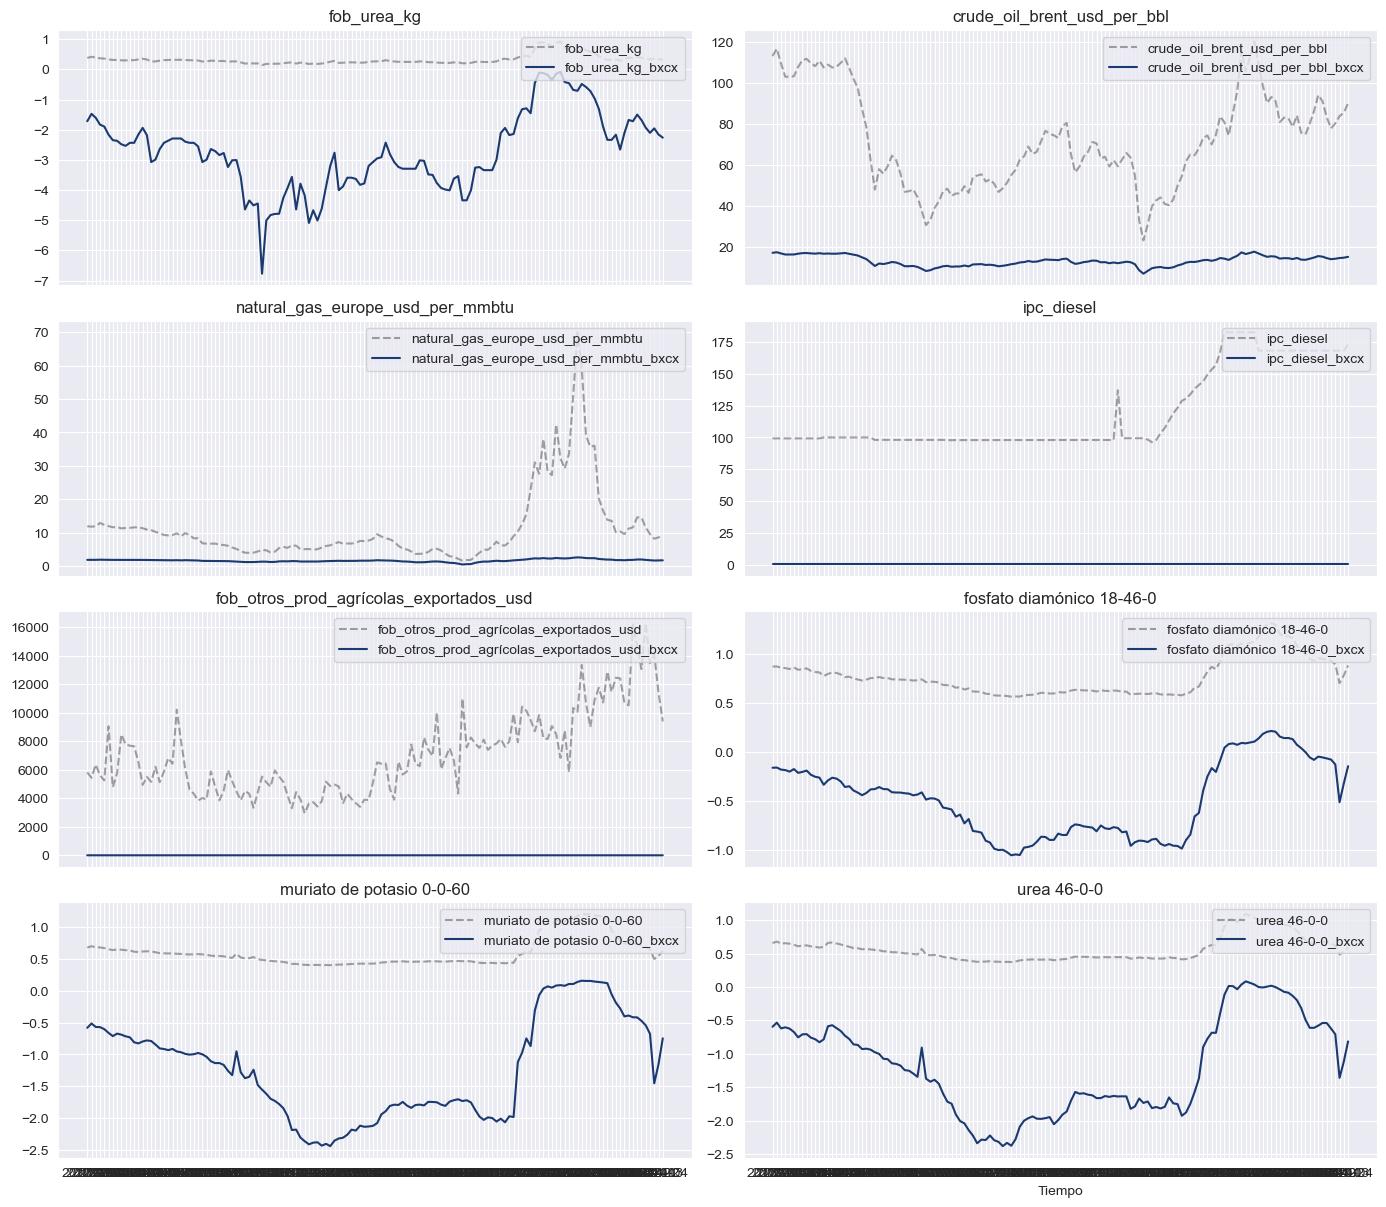

In [ ]:
plot_comparison(df_heterocedásticas, df_heterocedásticas_boxcox, suffix='_bxcx')

### Diferenciación estacional

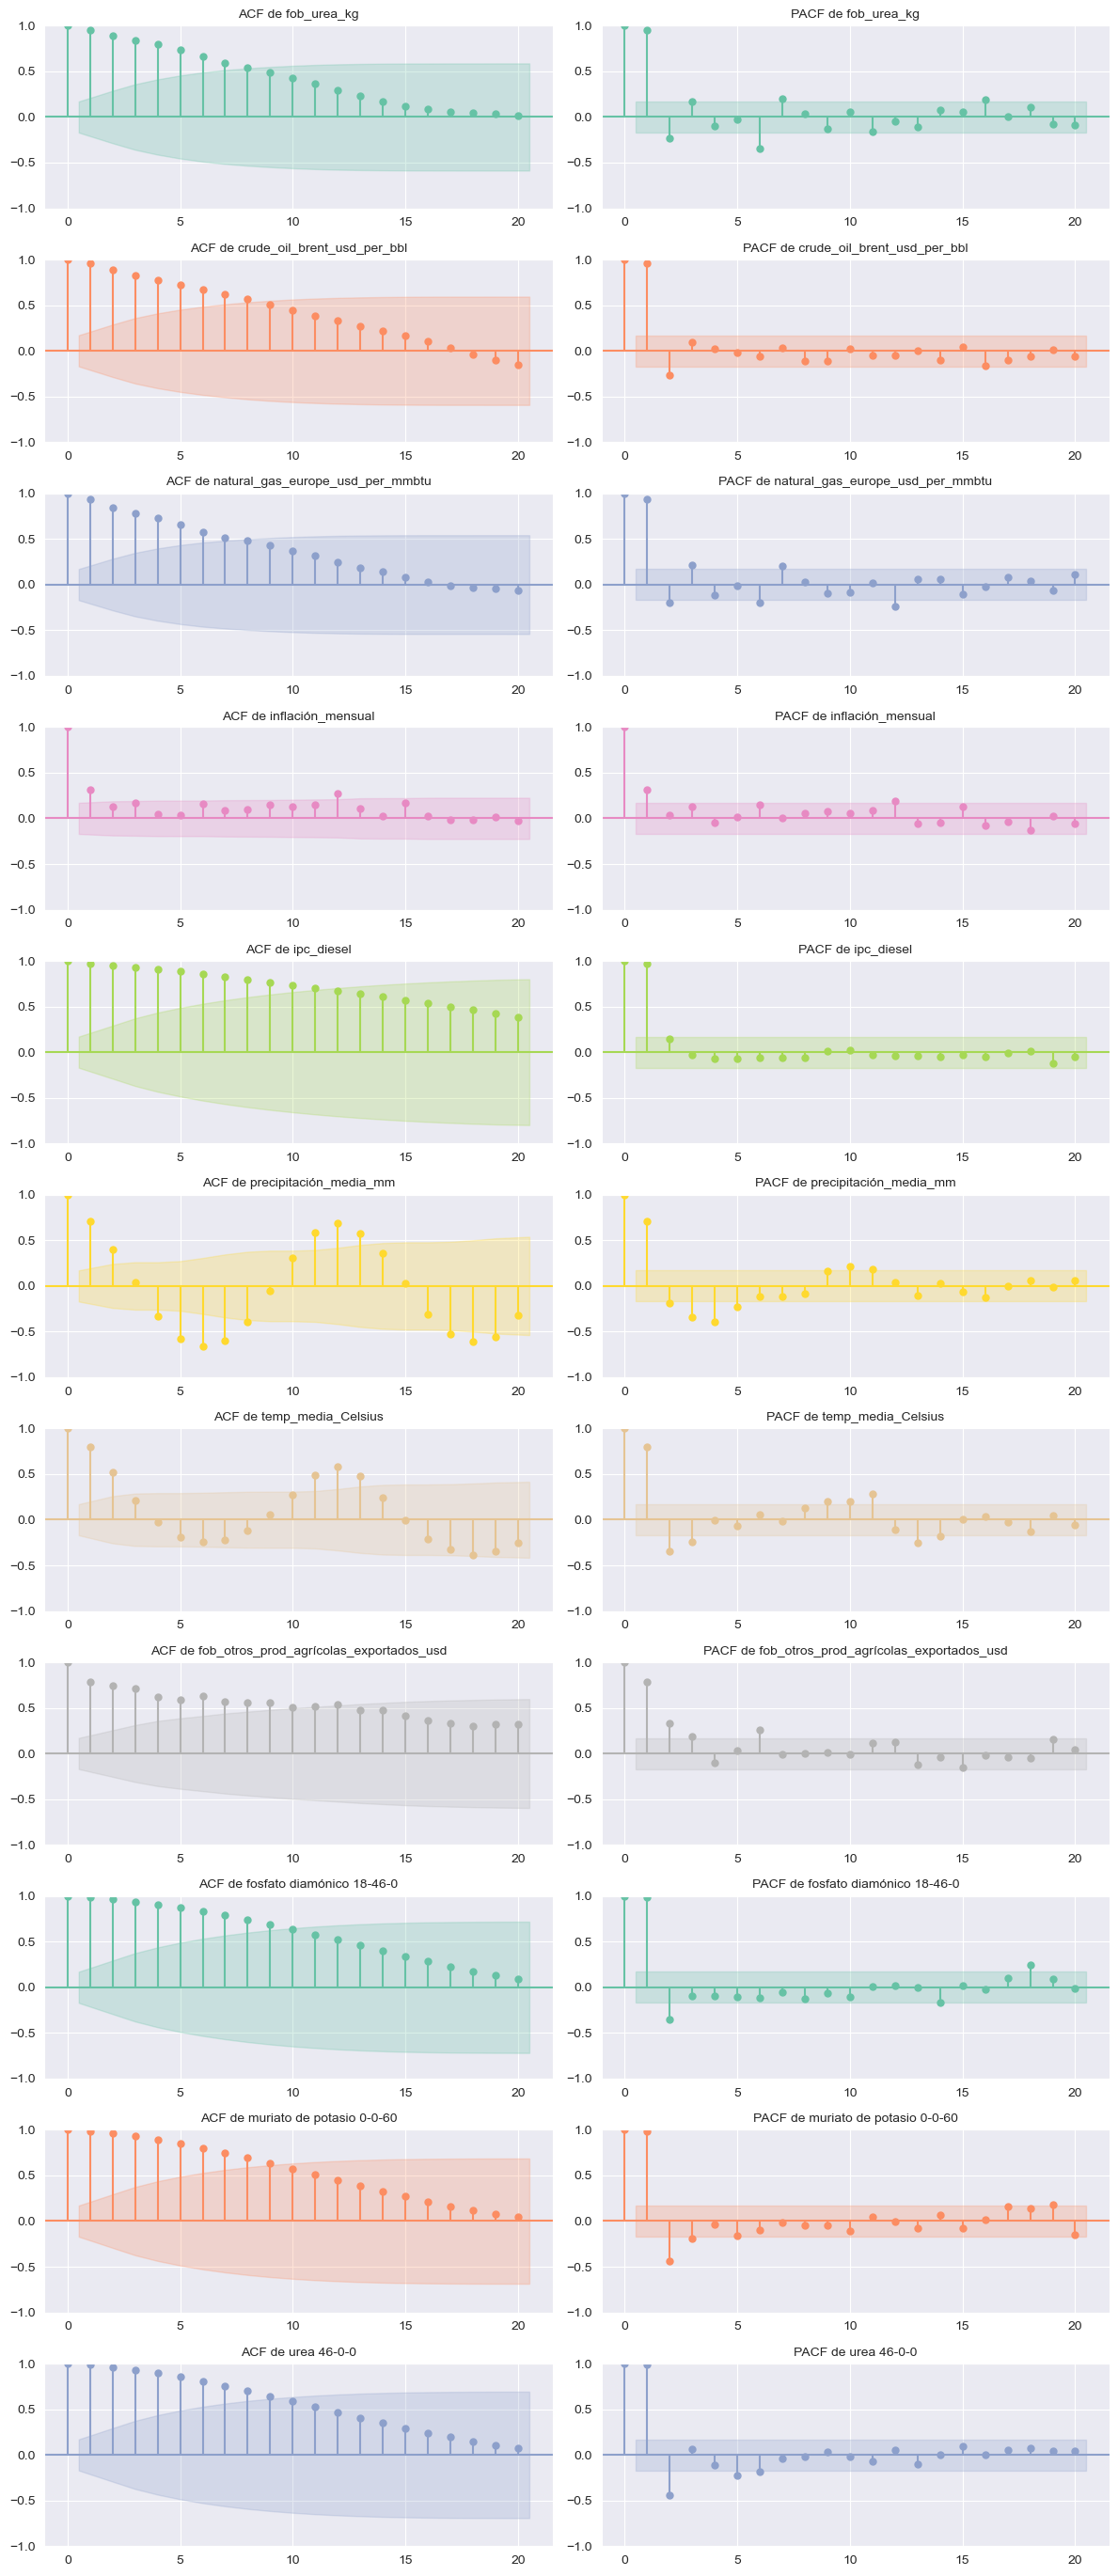

In [ ]:
plot_acf_pacf(df.dropna(), lags=20, color_palette='Set2')

In [ ]:
lista_var_estacionales = ['precipitación_media_mm', 'temp_media_Celsius']

var_estacionales = df[lista_var_estacionales].dropna()

var_estacionales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146 entries, 2011-11-30 to 2023-12-31
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   precipitación_media_mm  146 non-null    float64
 1   temp_media_Celsius      146 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


In [ ]:
from statsmodels.tsa.stattools import adfuller

for col in var_estacionales.columns:
# Prueba ADF con términos estacionales
    adf_result = adfuller(var_estacionales[col], regression='ct')  # 'ct' incluye tendencia y constante
    print(col, ":")
    print("-> ADF Statistic:", round(adf_result[0], 3))
    print("-> p-value:", round(adf_result[1], 3))

precipitación_media_mm :
-> ADF Statistic: -2.494
-> p-value: 0.331
temp_media_Celsius :
-> ADF Statistic: -1.702
-> p-value: 0.75


Los resultados de la prueba ADF con tendencia y constante (regression='ct') en las series de precipitación media (mm) y temperatura media (°C) muestran valores p altos (0.239 y 0.782, respectivamente), lo que indica que no se puede rechazar la hipótesis nula de raíz unitaria. Esto sugiere que ambas series son no estacionarias, incluso al ajustar una tendencia lineal. 

Por otra parte, la estacionalidad inherente en estas variables podría requerir una diferenciación estacional adicional para estabilizar la serie y eliminar patrones cíclicos, permitiendo su análisis con modelos que asumen estacionariedad.

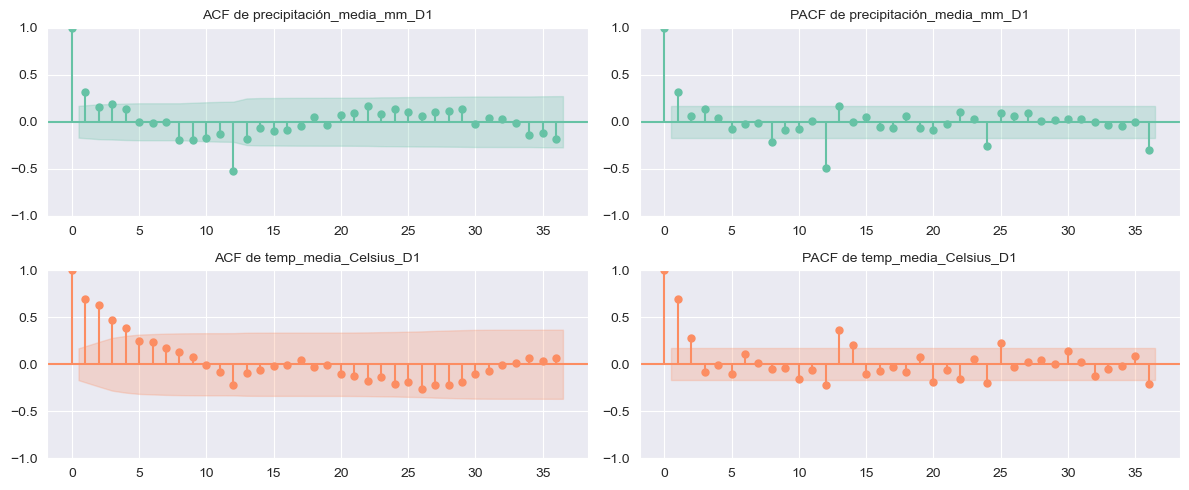

In [ ]:
diff_estacional = var_estacionales.diff(12).add_suffix("_D1").dropna()

plot_acf_pacf(diff_estacional, lags=36, color_palette='Set2')

Un pico significativo en el lag estacional (12) del ACF en  es un patrón común y esperado en series originalmente estacionales y no requiere más transformaciones si la serie es estacionaria tras la diferenciación. Notamos este patrón en el ACF de `precipitación_media_mm_D1` mas no en `temp_media_Celsius_D1`.

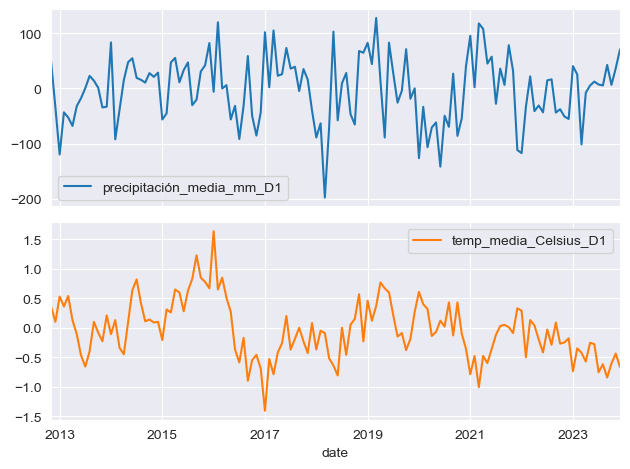

In [ ]:
diff_estacional.plot(subplots=True)
plt.tight_layout()
plt.show()

En los gráficos de línea de las series con diferenciación estacional D=1 (12 períodos), notamos que la varianza de `precipitación_media_mm_D1`; no así la varianza de `temp_media_Celsius_D1`.

Estacionareidad evaluada por *Augmented Dickey-Fuller* (ADF) y *Kwiatkowski-Phillips-Schmidt-Shin* (KPSS):

In [ ]:
diff_estacional = diff_estacional.dropna()

evaluar_estacionareidad_series_estacionales = evaluar_estacionareidad(diff_estacional)

evaluar_estacionareidad_series_estacionales

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,precipitación_media_mm_D1,0.000092,0.100000,True,False,Estacionario
1,temp_media_Celsius_D1,0.517717,0.077895,False,False,No claro


**Conclusión:** La diferenciación estacional `D=1` convirtió la variable `precipitación_media_mm` en estacionaria exitosamente, pero `temp_media_Celsius_D1` requiere modelado adicional.

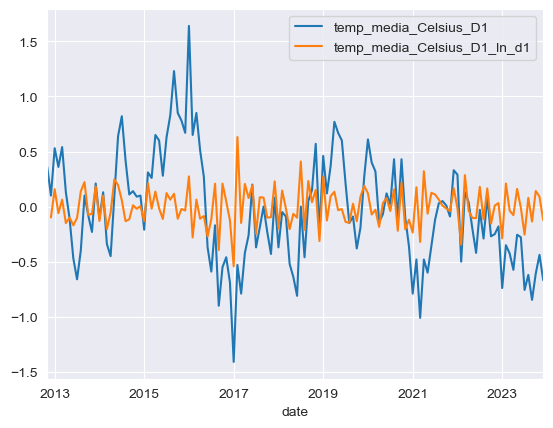

In [ ]:
# Aplicar transformaciones para que 'temp_media_Celsius_D1' alcance estacionareidad:
diff_estacional['temp_media_Celsius_D1_ln_d1'] = diff_estacional['temp_media_Celsius_D1']\
    .add(-diff_estacional['temp_media_Celsius_D1'].min() + 1)\
    .apply(np.log)\
    .diff()

# Comparación visual entre 
diff_estacional['temp_media_Celsius_D1'].plot()
diff_estacional['temp_media_Celsius_D1_ln_d1'].plot()
plt.legend()
plt.show()

In [ ]:
diff_estacional = diff_estacional.dropna()

evaluar_estacionareidad_series_estacionales = evaluar_estacionareidad(diff_estacional)

evaluar_estacionareidad_series_estacionales

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,precipitación_media_mm_D1,0.000076,0.100000,True,False,Estacionario
1,temp_media_Celsius_D1,0.518581,0.082785,False,False,No claro
2,temp_media_Celsius_D1_ln_d1,0.000002,0.100000,True,False,Estacionario


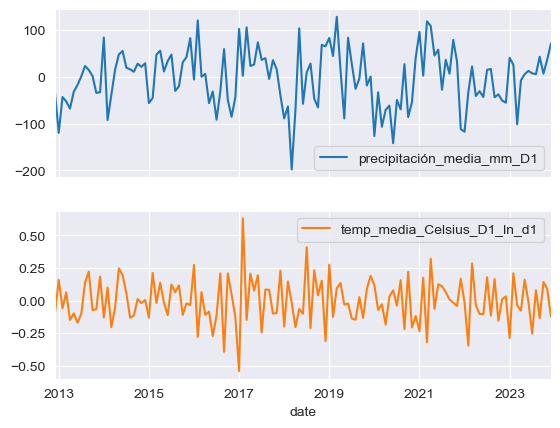

In [ ]:
var_estacionales_estacionarias = diff_estacional.drop(columns=['temp_media_Celsius_D1'])

var_estacionales_estacionarias.plot(subplots=True)
plt.show()

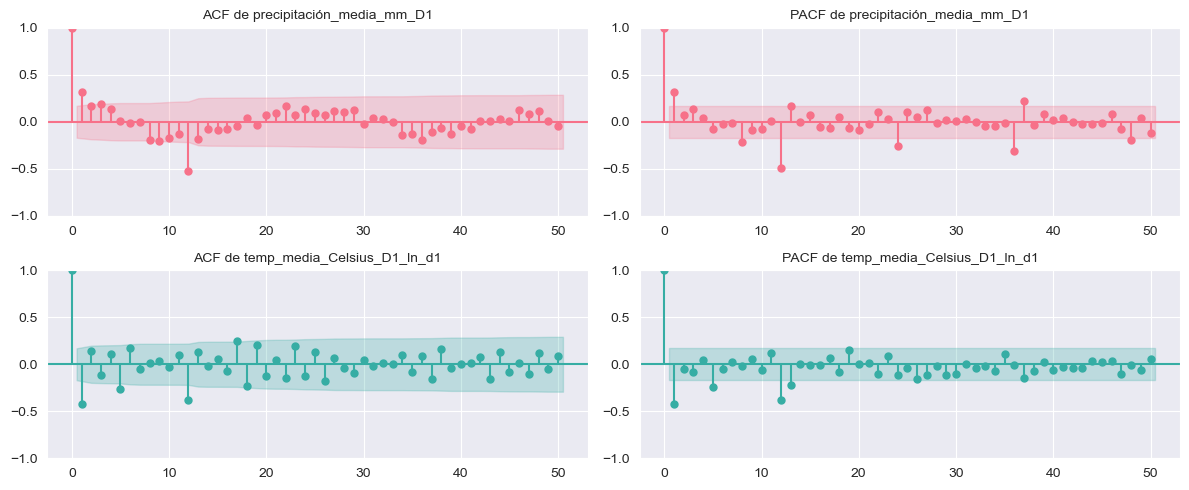

In [ ]:
plot_acf_pacf(var_estacionales_estacionarias.dropna(), lags=50)

In [ ]:
var_estacionales_estacionarias.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2012-12-31 to 2023-12-31
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   precipitación_media_mm_D1    133 non-null    float64
 1   temp_media_Celsius_D1_ln_d1  133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


### Variables no estacionales

In [ ]:
y = 'urea 46-0-0'

# Eliminar valores nulos para análisis de estacionareidad:
var_no_estacionales = df.drop(columns=lista_var_estacionales)['2012-11-30':'2024-03-31'].dropna()

var_no_estacionales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2013-01-31 to 2024-03-31
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              135 non-null    float64
 1   crude_oil_brent_usd_per_bbl              135 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         135 non-null    float64
 3   inflación_mensual                        135 non-null    float64
 4   ipc_diesel                               135 non-null    float64
 5   fob_otros_prod_agrícolas_exportados_usd  135 non-null    float64
 6   fosfato diamónico 18-46-0                135 non-null    float64
 7   muriato de potasio 0-0-60                135 non-null    float64
 8   urea 46-0-0                              135 non-null    float64
dtypes: float64(9)
memory usage: 10.5 KB


In [ ]:
# Extraer valores de meses para creación de índices tras diferenciación:
mes_2 = var_no_estacionales.index.min() + pd.DateOffset(months=1)
mes_2 = mes_2.strftime('%Y-%m')

mes_3 = var_no_estacionales.index.min() + pd.DateOffset(months=2)
mes_3 = mes_3.strftime('%Y-%m')

mes_4 = var_no_estacionales.index.min() + pd.DateOffset(months=3)
mes_4 = mes_4.strftime('%Y-%m')

último_mes = var_no_estacionales.index.max() + pd.DateOffset(months=1)
último_mes = último_mes.strftime('%Y-%m')

In [ ]:
# Evaluar estadísticos ADF y KPSS de estacionareidad sobre datos originales:
df_test_estacionareidad = evaluar_estacionareidad(var_no_estacionales)

df_test_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg,2.193963e-01,0.023028,False,True,No estacionario
1,crude_oil_brent_usd_per_bbl,1.134769e-01,0.100000,False,False,No claro
2,natural_gas_europe_usd_per_mmbtu,2.682730e-01,0.038309,False,True,No estacionario
3,inflación_mensual,3.809845e-13,0.085182,True,False,Estacionario
4,ipc_diesel,9.595216e-01,0.010000,False,True,No estacionario
5,fob_otros_prod_agrícolas_exportados_usd,9.985632e-01,0.010000,False,True,No estacionario
6,fosfato diamónico 18-46-0,1.518363e-01,0.023557,False,True,No estacionario
7,muriato de potasio 0-0-60,3.831017e-01,0.022372,False,True,No estacionario
8,urea 46-0-0,1.463115e-01,0.026651,False,True,No estacionario


#### Diferenciación d=1:

In [ ]:
q_inferior = 0
q_superior = 1

In [ ]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

# Extraer nombres de variables que no son originalmente estacionarias:
variables_no_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] != 'Estacionario']['variable'].values

# Crear un df de variables no estacionarias:
df_no_estacionarias = var_no_estacionales[variables_no_estacionarias]


In [ ]:
# Diferenciar para d=1 y agregar sufijo:
df_no_estacionarias_diferenciadas_d1 = df_no_estacionarias\
    .apply(np.diff, n=1)\
    .add_suffix("_d1")

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d1.index = pd.date_range(start=mes_2, end=último_mes, freq='ME')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d1_tmd = df_no_estacionarias_diferenciadas_d1\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

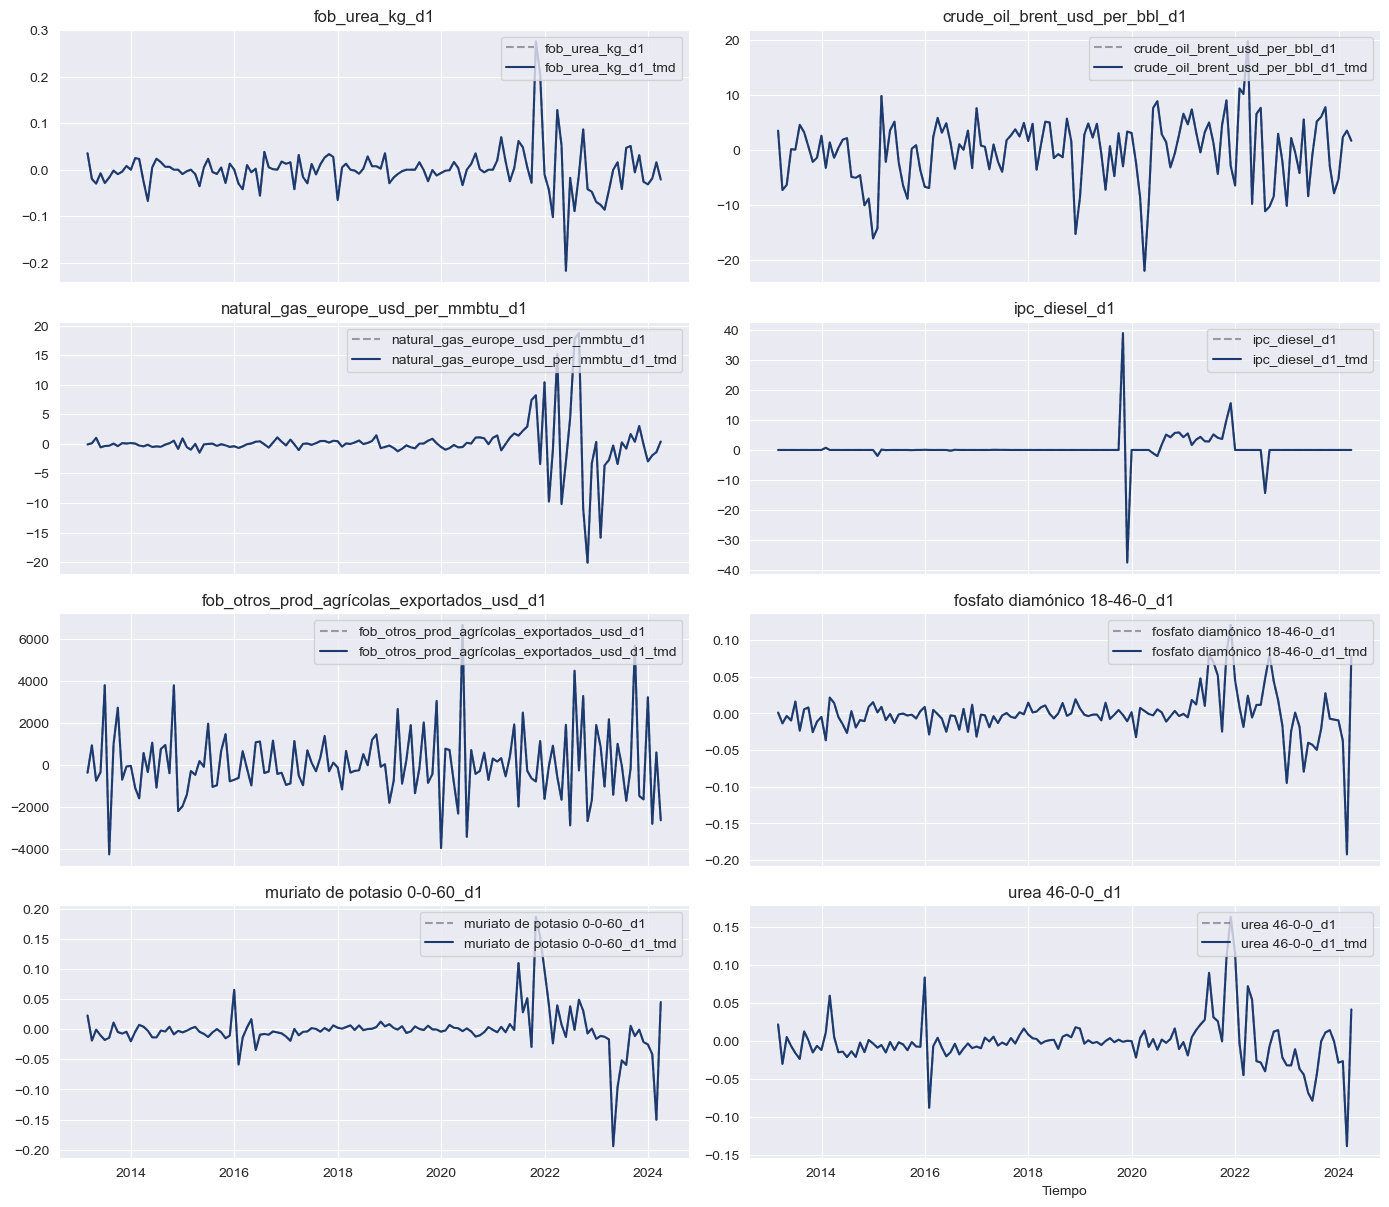

In [ ]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d1, df_no_estacionarias_diferenciadas_d1_tmd, suffix='_tmd')

In [ ]:
# Evaluar estadísticos ADF y KPSS de estacionareidad tras diferenciación d=1 y recorte:
df_test_estacionareidad_d1 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d1_tmd)

df_test_estacionareidad_d1

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg_d1,5.245918e-04,0.1,True,False,Estacionario
1,crude_oil_brent_usd_per_bbl_d1,1.056183e-11,0.1,True,False,Estacionario
2,natural_gas_europe_usd_per_mmbtu_d1,1.061201e-05,0.1,True,False,Estacionario
3,ipc_diesel_d1,3.394431e-28,0.1,True,False,Estacionario
4,fob_otros_prod_agrícolas_exportados_usd_d1,7.542547e-02,0.1,False,False,No claro
5,fosfato diamónico 18-46-0_d1,1.819057e-13,0.1,True,False,Estacionario
6,muriato de potasio 0-0-60_d1,1.998132e-05,0.1,True,False,Estacionario
7,urea 46-0-0_d1,5.160035e-02,0.1,False,False,No claro


In [ ]:
# Extraer nombres de variables que no son estacionarias después de d=1 pero antes del recorte:
variables_no_estacionarias_tras_d1 = df_test_estacionareidad_d1[df_test_estacionareidad_d1['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d1_tmd = df_no_estacionarias_diferenciadas_d1_tmd\
    .drop(columns=variables_no_estacionarias_tras_d1)\
    # .add_suffix('_tmd')

df_variables_estacionarias_d1_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2013-02-28 to 2024-03-31
Freq: M
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   fob_urea_kg_d1                       134 non-null    float64
 1   crude_oil_brent_usd_per_bbl_d1       134 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu_d1  134 non-null    float64
 3   ipc_diesel_d1                        134 non-null    float64
 4   fosfato diamónico 18-46-0_d1         134 non-null    float64
 5   muriato de potasio 0-0-60_d1         134 non-null    float64
dtypes: float64(6)
memory usage: 7.3 KB


#### Diferenciación d=2:

In [ ]:
# Crear un df de variables no estacionarias tras d=1 pero antes del recorte de extremos:
df_no_estacionarias_d1 = df_no_estacionarias_diferenciadas_d1[variables_no_estacionarias_tras_d1]

# Segunda diferenciación de variables no estacionarias tras d=1:
df_no_estacionarias_diferenciadas_d2 = df_no_estacionarias_d1.apply(np.diff, n=1)

# Cambiar el nombre de columnas para identificar 'd=2':
df_no_estacionarias_diferenciadas_d2.columns = [col.replace("_d1", "_d2") for col in df_no_estacionarias_diferenciadas_d2.columns]

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d2.index = pd.date_range(start=mes_3, end=último_mes, freq='ME')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d2_tmd = df_no_estacionarias_diferenciadas_d2\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

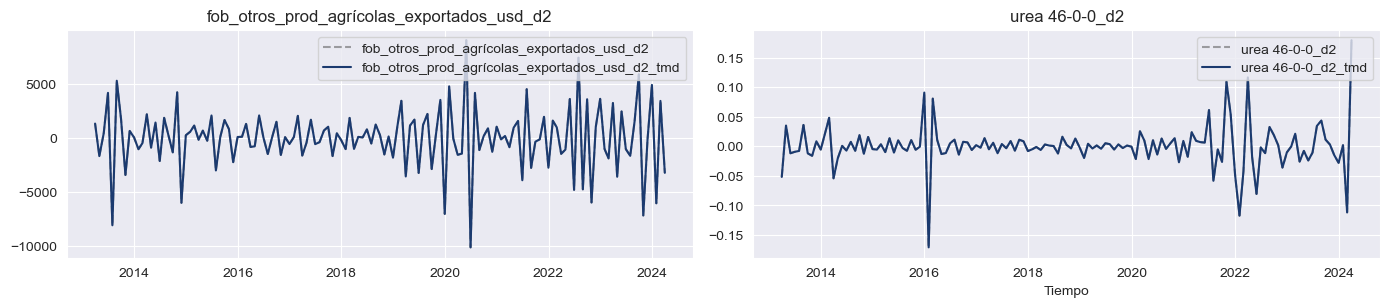

In [ ]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d2, df_no_estacionarias_diferenciadas_d2_tmd, suffix='_tmd')

In [ ]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
df_test_estacionareidad_d2 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d2_tmd)

df_test_estacionareidad_d2

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_otros_prod_agrícolas_exportados_usd_d2,6.844011e-14,0.1,True,False,Estacionario
1,urea 46-0-0_d2,1.378120e-18,0.1,True,False,Estacionario


In [ ]:
# Extraer nombres de variables que no son estacionarias después de d=2 pero antes del recorte:
variables_no_estacionarias_tras_d2 = df_test_estacionareidad_d2[df_test_estacionareidad_d2['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d2_tmd = df_no_estacionarias_diferenciadas_d2_tmd\
    .drop(columns=variables_no_estacionarias_tras_d2)\
    # .add_suffix('_tmd')

df_variables_estacionarias_d2_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2013-03-31 to 2024-03-31
Freq: M
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   fob_otros_prod_agrícolas_exportados_usd_d2  133 non-null    float64
 1   urea 46-0-0_d2                              133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


#### Diferenciación d=3:

In [ ]:
# # Crear un df de variables no estacionarias tras d=2 pero antes del recorte de extremos:
# df_no_estacionarias_d2 = df_no_estacionarias_diferenciadas_d2[variables_no_estacionarias_tras_d2]

# # Tercera diferenciación de variables no estacionarias tras d=2:
# df_no_estacionarias_diferenciadas_d3 = df_no_estacionarias_d2.apply(np.diff, n=1)

# # Cambiar el nombre de columnas para identificar 'd=3':
# df_no_estacionarias_diferenciadas_d3.columns = [col.replace("_d2", "_d3") for col in df_no_estacionarias_diferenciadas_d3.columns]

# # Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
# df_no_estacionarias_diferenciadas_d3.index = pd.date_range(start=mes_4, end=último_mes, freq='ME')

# # Recortar valores extremos bajo criterio de cuantiles:
# df_no_estacionarias_diferenciadas_d3_tmd = df_no_estacionarias_diferenciadas_d3\
#     .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))


In [ ]:
# # Visualizar diferencias en datos tras recortes de valores extremos:
# plot_comparison(df_no_estacionarias_diferenciadas_d3, df_no_estacionarias_diferenciadas_d3_tmd, suffix='_tmd')

In [ ]:
# # Evaluar estadísticos ADF y KPSS de estacionareidad:
# df_test_estacionareidad_d3 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d3_tmd)

# df_test_estacionareidad_d3

In [ ]:
# # Extraer nombres de variables que no son estacionarias después de d=3 pero antes del recorte:
# variables_no_estacionarias_tras_d3 = df_test_estacionareidad_d3[df_test_estacionareidad_d3['estado_estacionario'] != 'Estacionario']['variable'].values

# # Obtener un DataFrame que solo contiene las variables estacionarias tras d=3 y eliminación de atípicos: 
# df_variables_estacionarias_d3_tmd = df_no_estacionarias_diferenciadas_d3_tmd\
#     .drop(columns=variables_no_estacionarias_tras_d3)\
#     .add_suffix('_tmd')

# df_variables_estacionarias_d3_tmd.info()

### Cohesión de variables estacionarias y con valores extremos recortados:

In [ ]:
# Extraer las variables originalmente estacionarias:
variables_originalmente_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] == 'Estacionario']['variable'].values

df_originalmente_estacionarias = var_no_estacionales[variables_originalmente_estacionarias]

df_estacionarios = pd.concat(
    [df_originalmente_estacionarias, var_estacionales_estacionarias, df_variables_estacionarias_d1_tmd, df_variables_estacionarias_d2_tmd], # df_variables_estacionarias_d3_tmd], 
    axis=1, 
    join='outer'
    )\
        ['2013':'2023']

df_estacionarios = df_estacionarios.fillna(df_estacionarios.median())\

df_estacionarios.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Freq: M
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   inflación_mensual                           132 non-null    float64
 1   precipitación_media_mm_D1                   132 non-null    float64
 2   temp_media_Celsius_D1_ln_d1                 132 non-null    float64
 3   fob_urea_kg_d1                              132 non-null    float64
 4   crude_oil_brent_usd_per_bbl_d1              132 non-null    float64
 5   natural_gas_europe_usd_per_mmbtu_d1         132 non-null    float64
 6   ipc_diesel_d1                               132 non-null    float64
 7   fosfato diamónico 18-46-0_d1                132 non-null    float64
 8   muriato de potasio 0-0-60_d1                132 non-null    float64
 9   fob_otros_prod_agrícolas_exportados_usd_d2  132 non-null    

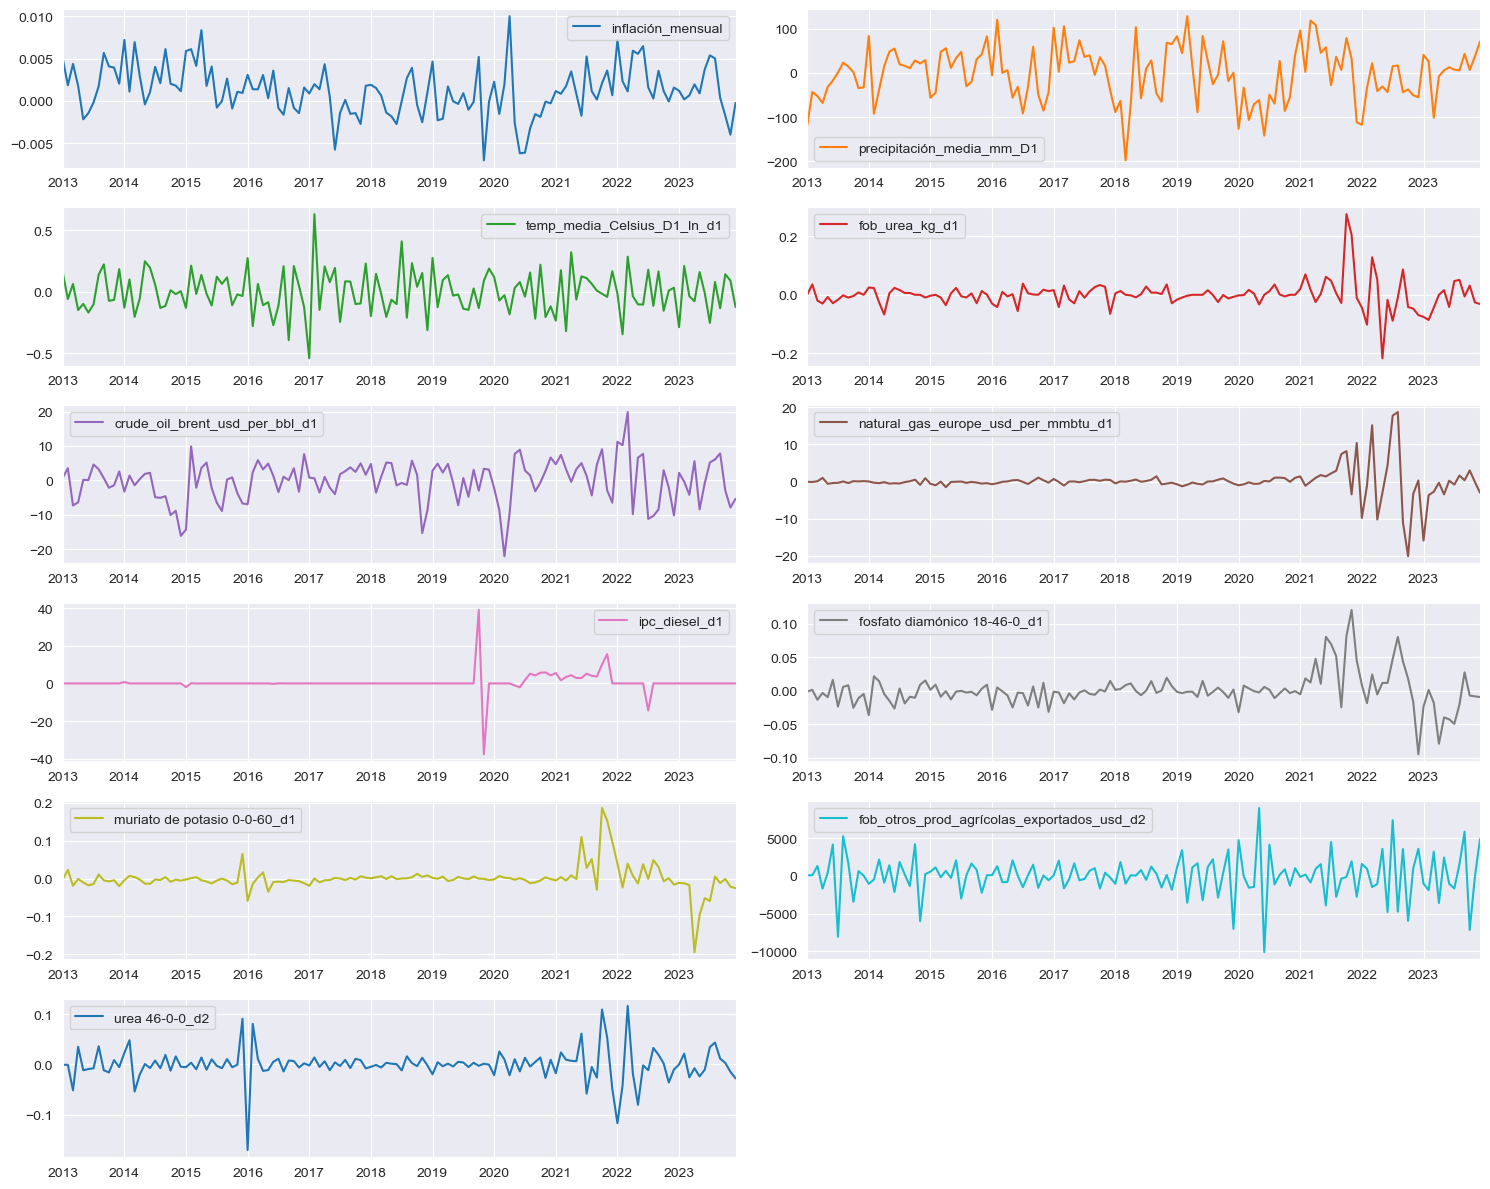

In [ ]:
num_de_filas = ((df_estacionarios.shape[1] + 1) // 2)

df_estacionarios.plot(
    subplots=True,
    layout=(num_de_filas, 2),
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )

plt.tight_layout()
plt.show()

In [ ]:
# df_estacionarios.to_csv('data/df_estacionarios.csv')

In [ ]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
verificar_estacionareidad = evaluar_estacionareidad(df_estacionarios)

verificar_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
1,precipitación_media_mm_D1,1.389231e-04,0.100000,True,False,Estacionario
2,temp_media_Celsius_D1_ln_d1,1.921345e-06,0.100000,True,False,Estacionario
3,fob_urea_kg_d1,5.776155e-04,0.100000,True,False,Estacionario
4,crude_oil_brent_usd_per_bbl_d1,2.690117e-13,0.100000,True,False,Estacionario
5,natural_gas_europe_usd_per_mmbtu_d1,1.324380e-05,0.100000,True,False,Estacionario
6,ipc_diesel_d1,4.765658e-28,0.100000,True,False,Estacionario
7,fosfato diamónico 18-46-0_d1,1.234462e-02,0.100000,True,False,Estacionario
8,muriato de potasio 0-0-60_d1,3.517005e-05,0.100000,True,False,Estacionario
9,fob_otros_prod_agrícolas_exportados_usd_d2,2.050004e-14,0.100000,True,False,Estacionario


In [ ]:
# Extraer variables predictoras:
X = df_estacionarios.drop(columns=['fosfato diamónico 18-46-0_d1', 'muriato de potasio 0-0-60_d1', 'urea 46-0-0_d2'])

# Extraer variable objetivo:
target_var = 'urea 46-0-0_d2'

y = df_estacionarios[target_var]

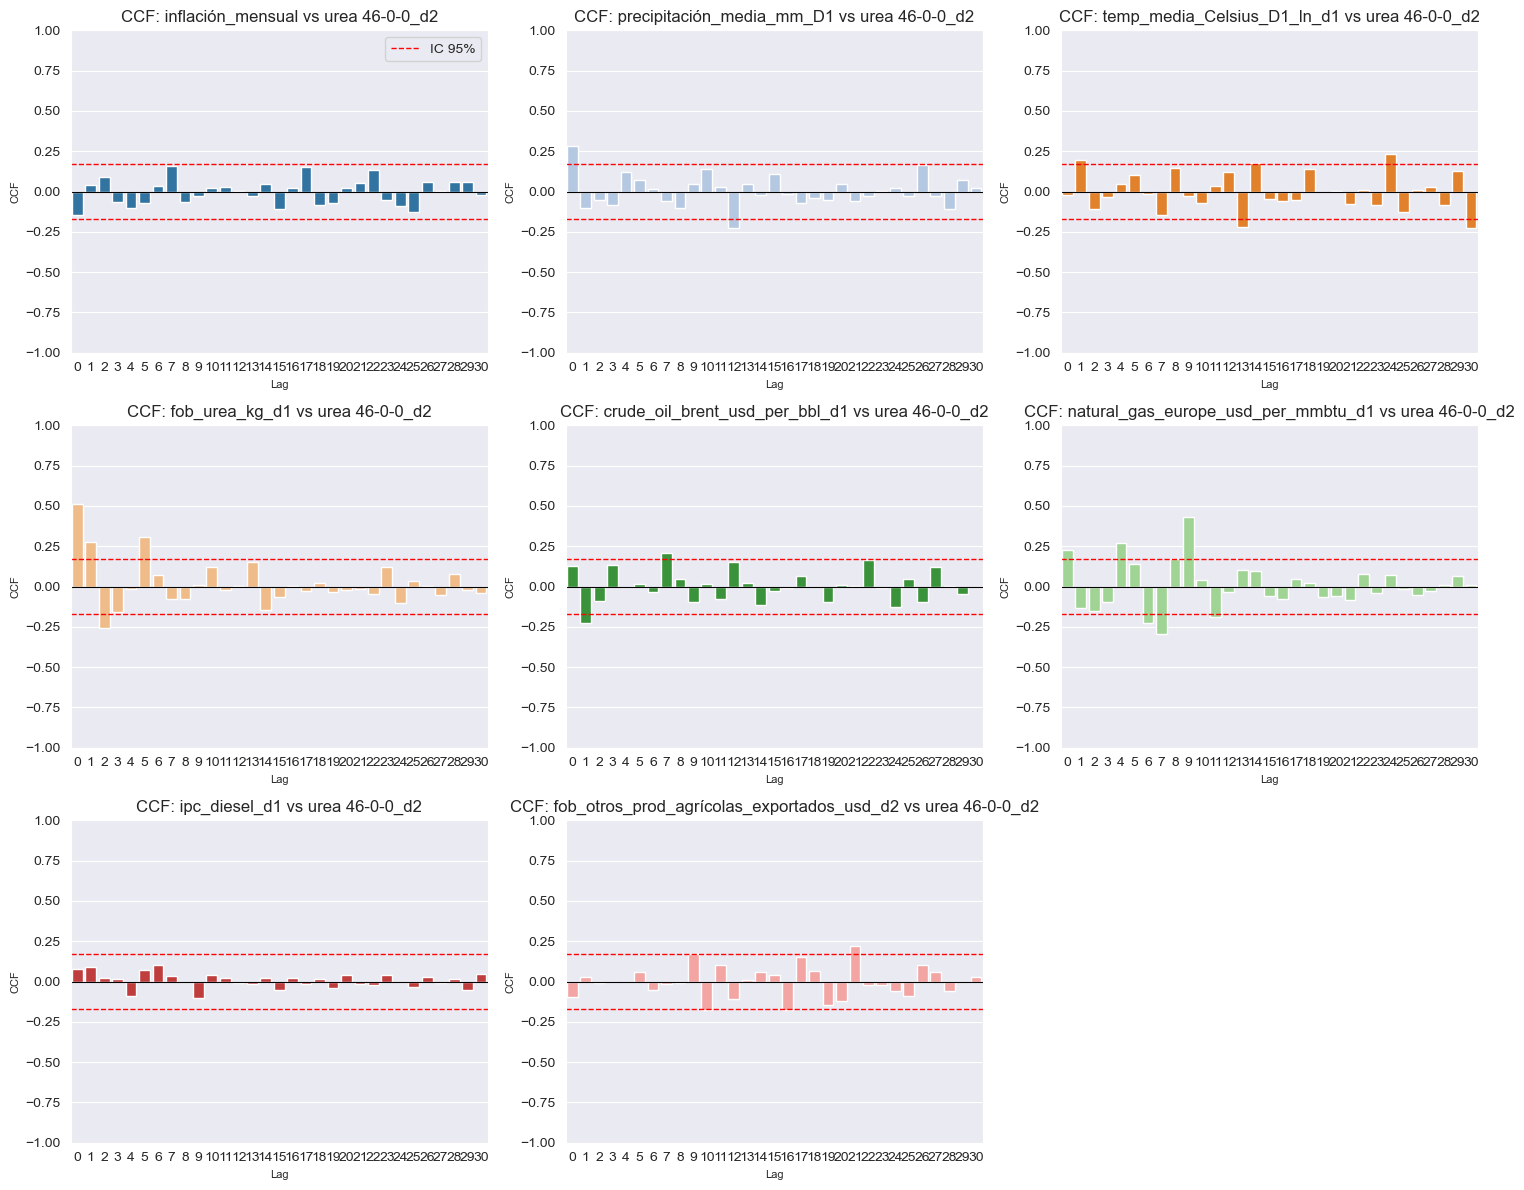

In [ ]:
plot_ccf_subplots(df_estacionarios, X.columns.tolist(), target_var, max_lag=30, palette_name="tab20")

### Regresión de variables no estacionarias

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crear un DataFrame para almacenar los VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
6,ipc_diesel_d1,1.186207
3,fob_urea_kg_d1,1.138433
0,inflación_mensual,1.096321
5,natural_gas_europe_usd_per_mmbtu_d1,1.058873
2,temp_media_Celsius_D1_ln_d1,1.057095
1,precipitación_media_mm_D1,1.053676
7,fob_otros_prod_agrícolas_exportados_usd_d2,1.027168
4,crude_oil_brent_usd_per_bbl_d1,1.010180


c:\Users\ivan_\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


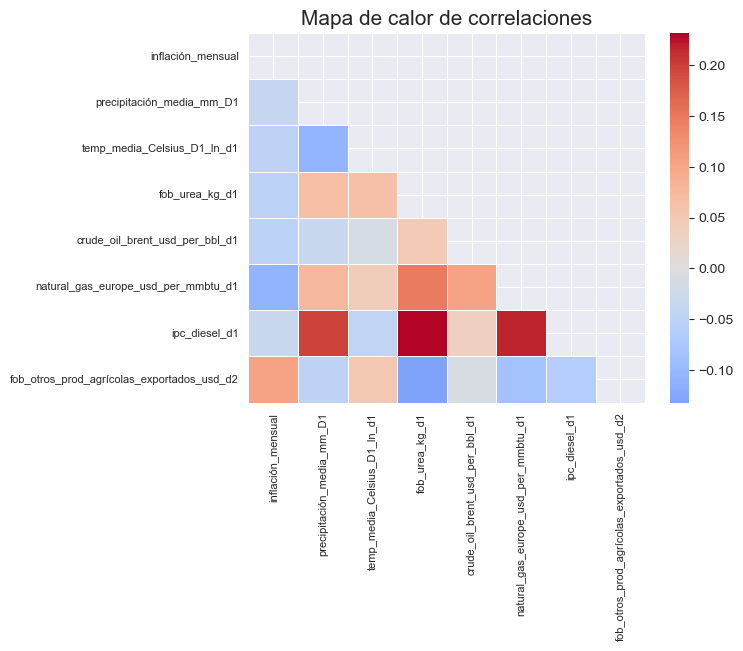

In [ ]:
# Graficar mapa de calor de correlaciones no lineales:
corr = X.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Agrega una constante para el intercepto
modelo_robusto = sm.OLS(y, X).fit(cov_type='HC0')  # Modelo robusto a heterocedasticidad
print(modelo_robusto.summary())

                            OLS Regression Results                            
Dep. Variable:         urea 46-0-0_d2   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     12.19
Date:               do., 24 nov. 2024   Prob (F-statistic):           1.01e-12
Time:                        20:04:32   Log-Likelihood:                 295.81
No. Observations:                 132   AIC:                            -573.6
Df Residuals:                     123   BIC:                            -547.7
Df Model:                           8                                         
Covariance Type:                  HC0                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

### Incremento del precio del gas natural en 2021 y su impacto en los costos de producción

En 2021, el precio del gas natural aumentó significativamente, marcando un posible cambio estructural en su dinámica de mercado. Este incremento estuvo impulsado por factores como la recuperación económica post-pandemia, inviernos más fríos y veranos más calurosos en Europa, una alta demanda de gas natural licuado (GNL) en Asia, y tensiones geopolíticas relacionadas con el suministro ruso. Además, la transición energética hacia fuentes renovables limitó las inversiones en gas fósil, restringiendo la capacidad de respuesta de la oferta ante el alza de la demanda.

El gas natural, como insumo principal en la producción de urea, sufrió un encarecimiento que afectó los costos de producción. Este impacto se trasladó al precio FOB (Free on Board) de la urea en mercados como Asia y al precio CIF (Cost, Insurance, and Freight) en países importadores como Ecuador. Dado que Ecuador importa principalmente urea desde Rusia, los precios reflejaron el aumento de los costos energéticos europeos.

El análisis de las series de tiempo de precios sugiere un posible cambio estructural a partir de 2021. Este cambio se caracteriza por un aumento persistente de precios, mayor volatilidad, y alteraciones en las correlaciones entre variables clave, como el gas natural y la urea. Los modelos tradicionales de series de tiempo pueden no ser suficientes para capturar estas nuevas dinámicas, lo que resalta la necesidad de segmentar temporalmente las series y considerar variables exógenas, como tensiones geopolíticas y costos energéticos.